In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from util_functions import plot_feature_with_anomalies, remove_outliers, remove_outliers_iqr

In [39]:
# Set Pandas to display all columns (None means no limit on the number of columns displayed)
pd.set_option('display.max_columns', None)

# Set option to display float format
pd.set_option('display.float_format', lambda x: '%.3f' % x) # This will help avoid issue of numeric values that are in the form of power (scientific notation) when you load them with pandas

In [40]:
# Function to check if variable is defined
def is_defined(variable_name):
    return variable_name in globals()

# Initial file paths
dasiv01 = 'Original_labeled_datasets/dt1_solar_and_meteorological_measurement.csv'
dasiv02 = 'Original_labeled_datasets/dt2_electrical_production_inverter_1_with_faults.csv'

# load the data if it is not already loaded
while not (is_defined('weather_data') and is_defined('df1')):
            weather_data = pd.read_csv(dasiv01, index_col='time')
            print("Weather data loaded successfully.")

            df1 = pd.read_csv(dasiv02, index_col='time')
            print("Electrical production data loaded successfully.")

df = df1.copy()
weather = weather_data.copy()

In [41]:
df = df.join(weather)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_convert(None) # Remove timezone information to avoid issues with decomposition

In [42]:
# rename the columns
df.rename(columns={'GTI': 'global_tilted_irradiance', 
                   'DTI': 'diffuse_tilted_irradiance', 
                   'TA': 'ambient_temperature', 
                   'TPV': 'panel_temperature', 
                   'Eg': 'energy_injected',
                   'Pg': 'power_injected', 
                   'Ia': 'ambient_current', 
                   'Ig': 'current_injected',
                   'Va': 'pv_plant_voltage',
                   'Vg': 'grid_voltage',
                   'Fg': 'grid_frequency'}, inplace=True)

## Denoise the data

### Wavelet denoising

In [58]:
import pywt

def wavelet_denoise(data, wavelet='sym8', level=3):
    data = data.values

    # Decompose the signal
    coeff = pywt.wavedec(data, wavelet, mode="per")
    
    # Calculate the threshold
    sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    
    # Apply thresholding
    coeff[1:] = [pywt.threshold(i, value=threshold, mode="soft") for i in coeff[1:]]
    
    # Reconstruct the signal
    return pywt.waverec(coeff, wavelet, mode="per")

### Slavitzky-Golay filter

In [81]:
from scipy.signal import savgol_filter

def savitzky_golay(data, window_length=4, polyorder=1):
    return pd.Series(savgol_filter(data, window_length, polyorder), index=data.index)

### Rolling median filter

In [89]:
def rolling_median_filter(data, window=5):
    return data.rolling(window=window, center=True, min_periods=1).median()

In [102]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Identify numerical columns
numeric_columns = df.drop(columns=['Fault']).select_dtypes(include=[np.number]).columns

# Apply wavelet denoising to each numerical column
for column in numeric_columns:
    df[f"{column}_denoised"] = rolling_median_filter(df[column])

C:\Users\AZIZON\AppData\Local\Temp\ipykernel_11328\467541991.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{column}_denoised"] = rolling_median_filter(df[column])
C:\Users\AZIZON\AppData\Local\Temp\ipykernel_11328\467541991.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{column}_denoised"] = rolling_median_filter(df[column])
C:\Users\AZIZON\AppData\Local\Temp\ipykernel_11328\467541991.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

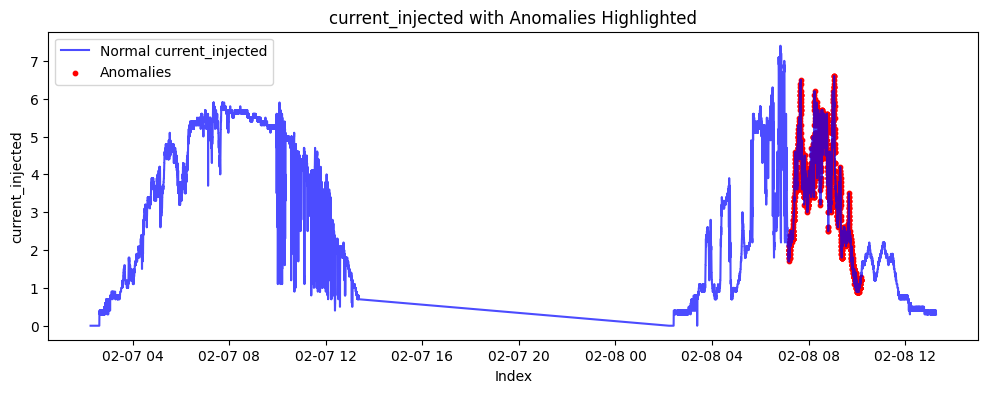

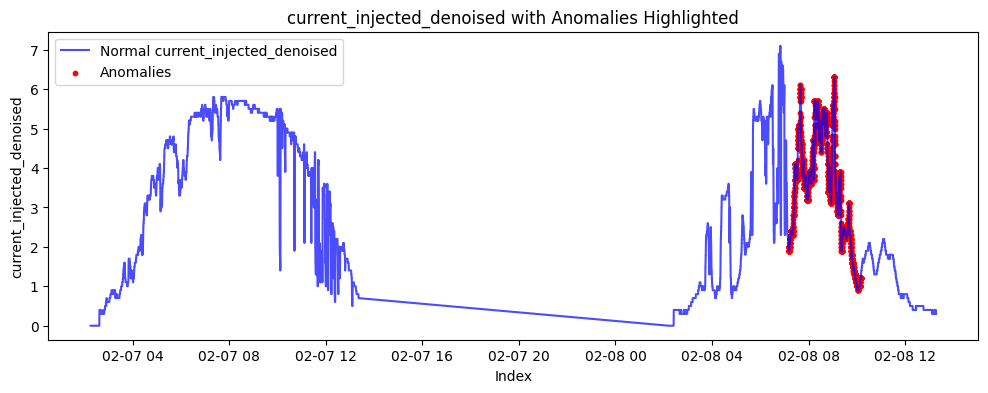

In [103]:
feature = 'current_injected'
start_date = '2022-02-07'
end_date = pd.to_datetime(start_date) + pd.Timedelta(days=2)

plot_feature_with_anomalies(df[start_date:end_date], feature)
plot_feature_with_anomalies(df[start_date:end_date], f'{feature}_denoised')

In [5]:
# Resample data to have different time intervals
df = df.resample('10min').agg({
    'global_tilted_irradiance': 'mean',
    'diffuse_tilted_irradiance': 'mean',
    'ambient_temperature': 'mean',
    'panel_temperature': 'mean',
    'energy_injected': 'sum',
    'power_injected': 'mean',
    'ambient_current': 'mean',
    'current_injected': 'mean',
    'pv_plant_voltage': 'mean',
    'grid_voltage': 'mean',
    'grid_frequency': 'mean',
    'Fault': 'mean'
})

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

### After resampling, the values in Fault column were affected, which is not recommended. I will round it.

In [7]:
df['Fault'] = df['Fault'].round()
non_zero_rows = df['Fault'].astype(bool).sum()
print("Number of rows with non-zero values in the 'Fault' column:", non_zero_rows)

Number of rows with non-zero values in the 'Fault' column: 803


<Axes: >

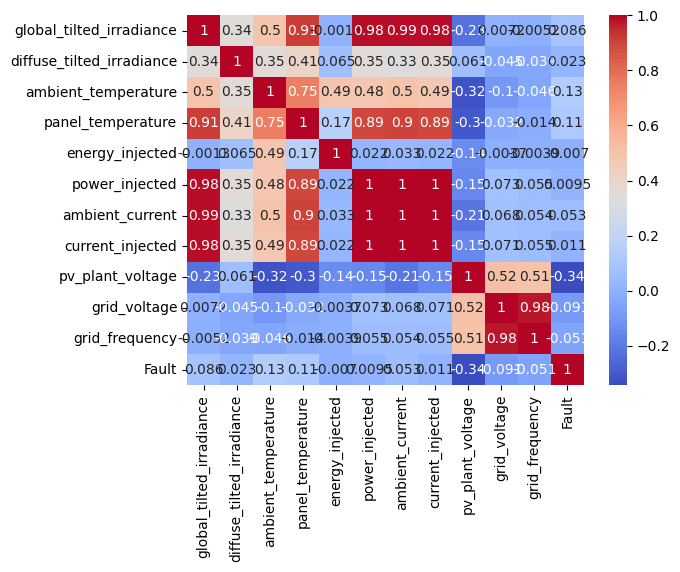

In [8]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### Change the values of Fault column. Set the values to 1 if they are not equal to 0.

In [ ]:
# convert other fault types to 1
df['Fault'] = df['Fault'].apply(lambda x: 1 if x != 0 else 0)

### Reorder the columns

In [ ]:
# Get all column names except 'fault'
cols = [c for c in df.columns if c != 'Fault']

# Append 'fault' column at the end
cols.append('Fault')

# Reorder the DataFrame using the new column order
df = df[cols]

#### Apply de-trending and de-seasoning

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

df_for_decomposition = df.copy()

full_index = pd.date_range(start='2021-10-27', end='2023-04-14', freq='10min')  # Fill in the gaps in the index of the data. '10T' for 10-minute intervals. 

# Reindex the DataFrame, you can choose a method to handle missing values
df_for_decomposition = df_for_decomposition.reindex(full_index, method='nearest')  # or use fillna() method after reindexing

for column in df_for_decomposition.drop('Fault', axis=1).columns:
    if kpss(df_for_decomposition[column])[1] > 0.05:  # If the time series is not stationary
        decomposed_column = sm.tsa.seasonal_decompose(df_for_decomposition[column], period=144)  # 144 periods is equivalent to 24 hours (144 * 10 minutes = 24 hours
        trend = decomposed_column.trend
        df_for_decomposition[column] = df_for_decomposition[column] - trend # Remove the trend from the original time series

# Update the original DataFrame with the decomposed values
df.update(df_for_decomposition.drop('Fault', axis=1))


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_20500\1191348826.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if kpss(df_for_decomposition[column])[1] > 0.05:  # If the time series is not stationary
C:\Users\AZIZON\AppData\Local\Temp\ipykernel_20500\1191348826.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if kpss(df_for_decomposition[column])[1] > 0.05:  # If the time series is not stationary
C:\Users\AZIZON\AppData\Local\Temp\ipykernel_20500\1191348826.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if kpss(df_for_decomposition[column])[1] > 0.05:  # If the time series is not stationary
C:\Users\AZIZON\App

#### Address outliers by capping their values

In [12]:
# address outliers by capping their values
# df = remove_outliers_iqr(df)
df = remove_outliers(df, lower_percentile=0.01, upper_percentile=0.99)

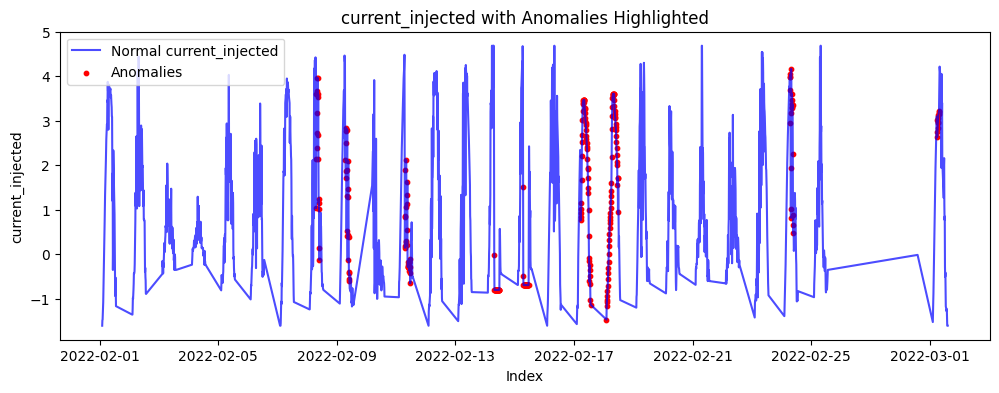

In [13]:
plot_feature_with_anomalies(df["2022-02-01":'2022-03-01'], 'current_injected')

In [14]:
# choose the directory of where GNNAD_testing files are located
df[:'2022-07-01'].to_csv('for_cross_validation.csv', index=True)